In [4]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

API_KEY = "5K2C96PUQWH9YWMX"

In [ ]:
# (5)
# opening and storing data

url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=IBM&apikey={API_KEY}'
r = requests.get(url)
data = r.json()

# storing in a dataframe 
df = pd.DataFrame(data['Time Series (Daily)']).T

# resetting index to have dates as a column
df.reset_index(inplace=True)

# renaming the columns
df.columns = ['date', 'open', 'high', 'low', 'close', 'volume']

# converting date column to datetime
df['date'] = pd.to_datetime(df['date'])

# filtering data for specified date range 
# we'll keep the datetime the same rather than turning it into a sequence of numbers
start_date = '2023-11-07'
end_date = '2024-03-26'
df_filtered = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

print(df_filtered)

# splitting into train and test sets (test = first 5 rows)
test = df_filtered.iloc[:5]
train = df_filtered.iloc[5:]


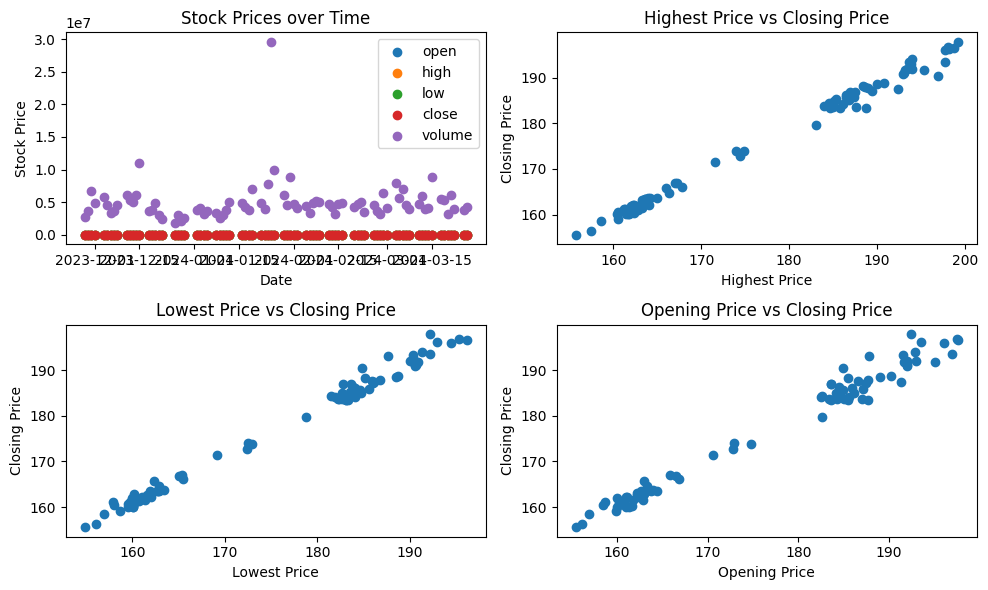

In [27]:
# (10)
# column names excluding date
column_names = ['open', 'high', 'low', 'close', 'volume']

# converting prices to numeric values (if they're not already)
df_filtered.loc[:, column_names] = df_filtered.loc[:, column_names].apply(pd.to_numeric)

# creating subplots for detailed relationships
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# plotting columns against date 
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Stock Price')
axes[0, 0].set_title('Stock Prices over Time')
for column in column_names:
    if column != 'date':
        axes[0, 0].scatter(df_filtered['date'], df_filtered[column], label=column)
axes[0, 0].legend()

# highest vs closing price
axes[0, 1].scatter(df_filtered['high'], df_filtered['close'])
axes[0, 1].set_xlabel('Highest Price')
axes[0, 1].set_ylabel('Closing Price')
axes[0, 1].set_title('Highest Price vs Closing Price')

# lowest vs closing price
axes[1, 0].scatter(df_filtered['low'], df_filtered['close'])
axes[1, 0].set_xlabel('Lowest Price')
axes[1, 0].set_ylabel('Closing Price')
axes[1, 0].set_title('Lowest Price vs Closing Price')

# opening vs closing price
axes[1, 1].scatter(df_filtered['open'], df_filtered['close'])
axes[1, 1].set_xlabel('Opening Price')
axes[1, 1].set_ylabel('Closing Price')
axes[1, 1].set_title('Opening Price vs Closing Price')

plt.tight_layout()
plt.show()

In [ ]:
# (15)
'''
Now that we’ve visualized our data, let's make a few conjectures about what to expect from our linear regression model. 
For each of the variable relationships you graphed above, which of them display a linear relationship? 
Which do not? Why or why not? 
'''

# Answer
'''
Of the graphs above, highest vs closing, lowest vs closing, and opening vs closing all display a linear relationship. 
In these graphs, the points tend to form a roughly straight line, showing a clear trend. 
The clustering of points around a sort of trend line indicate that there's a consistent relationship between the variables being plotted.

The graph displaying the relationship between stock price and date does not display a linear relationship.
The plot illustrates fluctuations, trends, and some irregular patterns over time. 
The data points are scattered across the plot and do not form a clear linear trend. 
It suggests that the relationship between stock price and date is more complex and dynamic, influenced by various factors.
'''